In [3]:
import pandas as pd
import numpy as np

df = pd.read_parquet("data/processed/features.parquet")
print(df.shape)
df.head()
df = pd.read_parquet("data/processed/features.parquet")


(10913850, 14)


In [5]:
TARGET = "item_cnt_month_clipped"

FEATURES = [
    "item_cnt_month_clipped_lag_1",
    "item_cnt_month_clipped_lag_2",
    "item_cnt_month_clipped_lag_3",
    "item_cnt_month_clipped_lag_6",
    "item_cnt_month_clipped_lag_12",
    "shop_month_mean_lag_1",
    "item_month_mean_lag_1",
]


In [6]:
train_df = df[df["date_block_num"] < 33]
valid_df = df[df["date_block_num"] == 33]

print(train_df.shape, valid_df.shape)


(10675678, 14) (238172, 14)


In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=1.0)
model.fit(train_df[FEATURES], train_df[TARGET])

preds = model.predict(valid_df[FEATURES])
preds = np.clip(preds, 0, 20)
mse = mean_squared_error(valid_df[TARGET], preds)
rmse = np.sqrt(mse)
print("RMSE validación:", rmse)

print("RMSE validación:", rmse)


RMSE validación: 0.9833670712242215
RMSE validación: 0.9833670712242215


In [9]:
# predecir siempre 0
pred_zero = np.zeros(len(valid_df))
rmse_zero = np.sqrt(mean_squared_error(valid_df[TARGET], pred_zero))

# predecir lo mismo que el mes pasado (lag_1)
pred_lag1 = valid_df["item_cnt_month_clipped_lag_1"].values
rmse_lag1 = np.sqrt(mean_squared_error(valid_df[TARGET], pred_lag1))

print("RMSE baseline (siempre 0):", rmse_zero)
print("RMSE baseline (lag_1):", rmse_lag1)
print("RMSE Ridge:", rmse)



RMSE baseline (siempre 0): 1.1652054223761361
RMSE baseline (lag_1): 1.1714459335072096
RMSE Ridge: 0.9833670712242215


In [10]:
valid_eval = valid_df.copy()
valid_eval["pred"] = preds
valid_eval["abs_error"] = (valid_eval[TARGET] - valid_eval["pred"]).abs()

valid_eval["abs_error"].describe()


count    238172.000000
mean          0.343259
std           0.921514
min           0.000194
25%           0.081505
50%           0.097768
75%           0.244348
max          19.918495
Name: abs_error, dtype: float64

In [11]:
valid_eval.sort_values("abs_error", ascending=False).head(20)[
    ["date_block_num", "shop_id", "item_id", TARGET, "pred", "abs_error",
     "item_cnt_month_clipped_lag_1", "item_cnt_month_clipped_lag_12",
     "shop_month_mean_lag_1", "item_month_mean_lag_1"]
]


,date_block_num,shop_id,item_id,item_cnt_month_clipped,pred,abs_error,item_cnt_month_clipped_lag_1,item_cnt_month_clipped_lag_12,shop_month_mean_lag_1,item_month_mean_lag_1
10773480,33,25,1578,20.0,0.081505,19.918495,0.0,0.0,0.0,0.0
10792114,33,31,11703,20.0,0.081505,19.918495,0.0,0.0,0.0,0.0
10754569,33,20,13233,20.0,0.081505,19.918495,0.0,0.0,0.0,0.0
10776259,33,25,13281,20.0,0.081505,19.918495,0.0,0.0,0.0,0.0
10710885,33,9,11530,20.0,0.081505,19.918495,0.0,0.0,0.0,0.0
10764678,33,22,10201,20.0,0.081505,19.918495,0.0,0.0,0.0,0.0
10754556,33,20,13218,20.0,0.081505,19.918495,0.0,0.0,0.0,0.0
10784310,33,28,1583,20.0,0.081505,19.918495,0.0,0.0,0.0,0.0
10774864,33,25,7223,20.0,0.081505,19.918495,0.0,0.0,0.0,0.0
10910829,33,59,10201,20.0,0.081505,19.918495,0.0,0.0,0.0,0.0


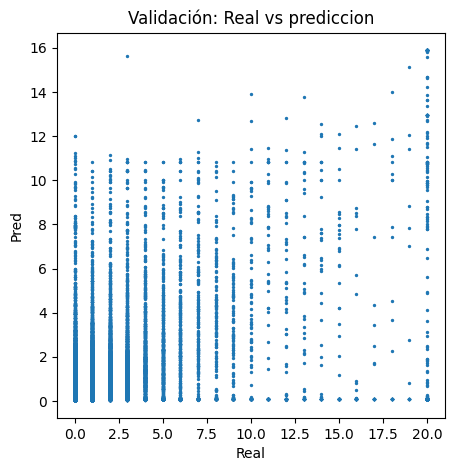

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(valid_eval[TARGET], valid_eval["pred"], s=2)
plt.xlabel("Real")
plt.ylabel("Pred")
plt.title("Validación: Real vs prediccion")
plt.show()


In [13]:
import joblib, os

os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/ridge_baseline.joblib")

print("Modelo guardado en models/ridge_baseline.joblib")


Modelo guardado en models/ridge_baseline.joblib


In [16]:
X_test = test_feats[FEATURES]

print("type:", type(X_test))
print("shape:", getattr(X_test, "shape", None))

# columnas duplicadas
dup = X_test.columns[X_test.columns.duplicated()].tolist()
print("duplicadas:", dup[:20], "total:", len(dup))

# dtypes
print(X_test.dtypes.value_counts())

# columnas object (suelen ser las culpables)
obj_cols = X_test.columns[X_test.dtypes == "object"].tolist()
print("object cols:", obj_cols)

if obj_cols:
    c = obj_cols[0]
    print("ejemplo col object:", c)
    print("tipo de un valor:", type(X_test[c].iloc[0]))
    print("valor:", X_test[c].iloc[0])



type: <class 'pandas.core.frame.DataFrame'>
shape: (214200, 7)
duplicadas: [] total: 0
float64    7
Name: count, dtype: int64
object cols: []


In [18]:
print("FEATURES len:", len(FEATURES))
print("X_test cols:", X_test.columns.tolist() if hasattr(X_test, "columns") else "no columns")
print("Faltan en test:", [c for c in FEATURES if c not in test_feats.columns])
print("Sobran en test:", [c for c in test_feats.columns if c not in FEATURES][:20])


FEATURES len: 7
X_test cols: no columns
Faltan en test: []
Sobran en test: ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_cnt_month_clipped', 'shop_month_mean', 'item_month_mean', 'ID']


In [20]:

missing = [c for c in FEATURES if c not in test_feats.columns]
for c in missing:
    test_feats[c] = 0  # o np.nan y luego fillna, pero 0 suele ser lo estándar aquí

X_test = test_feats[FEATURES].copy()

X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

preds_test = model.predict(X_test)
preds_test = np.clip(preds_test, 0, 20)


In [21]:
test_feats = df[df["date_block_num"] == 34].merge(test[["ID","shop_id","item_id"]], on=["shop_id","item_id"], how="right")


In [22]:
print(test_feats.shape)
print(test_feats.columns.tolist())


(214200, 15)
['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_cnt_month_clipped', 'item_cnt_month_clipped_lag_1', 'item_cnt_month_clipped_lag_2', 'item_cnt_month_clipped_lag_3', 'item_cnt_month_clipped_lag_6', 'item_cnt_month_clipped_lag_12', 'shop_month_mean', 'item_month_mean', 'shop_month_mean_lag_1', 'item_month_mean_lag_1', 'ID']


In [23]:
sub = test_feats[["ID"]].copy()
sub["item_cnt_month"] = preds_test
sub.to_csv("submission.csv", index=False)
sub.head()


,ID,item_cnt_month
0,0,0.081505
1,1,0.081505
2,2,0.081505
3,3,0.081505
4,4,0.081505


In [24]:
X_test = test_feats[FEATURES].copy()
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

print("shape:", X_test.shape)
print("sum all:", X_test.to_numpy().sum())
print("std mean:", X_test.stack().std())
print("nunique por columna (min..max):", X_test.nunique().min(), X_test.nunique().max())
X_test.describe().T.head(10)


shape: (214200, 7)
sum all: 0.0
std mean: 0.0
nunique por columna (min..max): 1 1


,count,mean,std,min,25%,50%,75%,max
item_cnt_month_clipped_lag_1,214200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_cnt_month_clipped_lag_2,214200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_cnt_month_clipped_lag_3,214200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_cnt_month_clipped_lag_6,214200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_cnt_month_clipped_lag_12,214200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
shop_month_mean_lag_1,214200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_month_mean_lag_1,214200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
print("FEATURES:", FEATURES)
print("train cols ok:", set(FEATURES).issubset(train_df.columns))
print("valid cols ok:", set(FEATURES).issubset(valid_df.columns))


FEATURES: ['item_cnt_month_clipped_lag_1', 'item_cnt_month_clipped_lag_2', 'item_cnt_month_clipped_lag_3', 'item_cnt_month_clipped_lag_6', 'item_cnt_month_clipped_lag_12', 'shop_month_mean_lag_1', 'item_month_mean_lag_1']
train cols ok: True
valid cols ok: True


In [26]:
missing = [c for c in FEATURES if c not in test_feats.columns]
extra = [c for c in test_feats.columns if c in FEATURES]
print("missing in test_feats:", missing)
print("num features in test:", len(extra), "expected:", len(FEATURES))


missing in test_feats: []
num features in test: 7 expected: 7


In [27]:
print("coef mean abs:", np.mean(np.abs(model.coef_)))
print("intercept:", model.intercept_)


coef mean abs: 0.1211123977752875
intercept: 0.08150526798554061


In [28]:
preds_test = model.predict(X_test)
preds_test = np.clip(preds_test, 0, 20)

print(preds_test.min(), preds_test.mean(), preds_test.max())
pd.Series(preds_test).describe()


0.08150526798554061 0.0815052679855406 0.08150526798554061


count    2.142000e+05
mean     8.150527e-02
std      1.387782e-17
min      8.150527e-02
25%      8.150527e-02
50%      8.150527e-02
75%      8.150527e-02
max      8.150527e-02
dtype: float64

In [29]:
sub = test_feats[["ID"]].copy()
sub["item_cnt_month"] = preds_test.astype(float)
sub.to_csv("submission.csv", index=False)
sub.head()


,ID,item_cnt_month
0,0,0.081505
1,1,0.081505
2,2,0.081505
3,3,0.081505
4,4,0.081505


In [32]:


missing = [c for c in FEATURES if c not in test_feats.columns]
print("Missing:", missing)

for c in missing:
    test_feats[c] = 0.0

X_test = test_feats[FEATURES].copy()

# Limpieza
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

# Predice
preds_test = model.predict(X_test)
preds_test = np.clip(preds_test, 0, 20)


Missing: ['shop_month_mean_lag_1', 'item_month_mean_lag_1']


In [34]:
# 1) Crea tabla con mean por shop/item y mes
shop_month_mean = (
    df.groupby(["date_block_num","shop_id"], as_index=False)["item_cnt_month_clipped"]
      .mean()
      .rename(columns={"item_cnt_month_clipped":"shop_month_mean"})
)
item_month_mean = (
    df.groupby(["date_block_num","item_id"], as_index=False)["item_cnt_month_clipped"]
      .mean()
      .rename(columns={"item_cnt_month_clipped":"item_month_mean"})
)

# 2) Genera lag 1
shop_month_mean["shop_month_mean_lag_1"] = shop_month_mean.groupby("shop_id")["shop_month_mean"].shift(1)
item_month_mean["item_month_mean_lag_1"] = item_month_mean.groupby("item_id")["item_month_mean"].shift(1)

# 3) Filtra SOLO mes 34 (porque eso vas a mergear a test)
shop_lag34 = shop_month_mean[shop_month_mean["date_block_num"]==34][["shop_id","shop_month_mean_lag_1"]]
item_lag34 = item_month_mean[item_month_mean["date_block_num"]==34][["item_id","item_month_mean_lag_1"]]

# 4) Merge a tu test_feats
test_feats = test_feats.merge(shop_lag34, on="shop_id", how="left")
test_feats = test_feats.merge(item_lag34, on="item_id", how="left")

# 5) fillna (si no existe el shop/item en el mes previo, 0)
test_feats[["shop_month_mean_lag_1","item_month_mean_lag_1"]] = test_feats[["shop_month_mean_lag_1","item_month_mean_lag_1"]].fillna(0)


KeyError: "None of [Index(['shop_month_mean_lag_1', 'item_month_mean_lag_1'], dtype='object')] are in the [columns]"

In [35]:
[c for c in test_feats.columns if "lag_1" in c]



['item_cnt_month_clipped_lag_1',
 'item_cnt_month_clipped_lag_12',
 'shop_month_mean_lag_1_x',
 'item_month_mean_lag_1_x',
 'shop_month_mean_lag_1_y',
 'item_month_mean_lag_1_y']

In [36]:
need = ["shop_month_mean_lag_1", "item_month_mean_lag_1"]

for c in need:
    if c not in test_feats.columns:
        # si se creó con sufijo _x/_y por colisión, lo detectamos
        candidates = [col for col in test_feats.columns if col.startswith(c)]
        if len(candidates) > 0:
            test_feats.rename(columns={candidates[0]: c}, inplace=True)
        else:
            # si de plano no existe, la creamos en 0
            test_feats[c] = 0.0

test_feats[need] = test_feats[need].fillna(0)


In [37]:
test_feats[["shop_month_mean_lag_1","item_month_mean_lag_1"]].describe()


,shop_month_mean_lag_1,item_month_mean_lag_1
count,214200.0,214200.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [38]:
X_test = test_feats[FEATURES].copy()
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

preds_test = np.clip(model.predict(X_test), 0, 20)


In [39]:
[c for c in test_feats.columns if "lag_1" in c]


['item_cnt_month_clipped_lag_1',
 'item_cnt_month_clipped_lag_12',
 'shop_month_mean_lag_1',
 'item_month_mean_lag_1',
 'shop_month_mean_lag_1_y',
 'item_month_mean_lag_1_y']

In [40]:
# 1) Quédate SOLO con las columnas "buenas" (sin sufijos)
cols_to_drop = [c for c in test_feats.columns if c.endswith("_y") or c.endswith("_x")]
test_feats = test_feats.drop(columns=cols_to_drop, errors="ignore")

# 2) Asegura que existan las features necesarias (por si algo faltara)
need = ["shop_month_mean_lag_1", "item_month_mean_lag_1"]
for c in need:
    if c not in test_feats.columns:
        test_feats[c] = 0.0

# 3) Limpieza
test_feats[need] = test_feats[need].replace([np.inf, -np.inf], np.nan).fillna(0)


In [45]:
X_test = test_feats[FEATURES].copy() 
test_feats[["shop_month_mean_lag_1","item_month_mean_lag_1"]].describe()

X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

preds_test = np.clip(model.predict(X_test), 0, 20)


In [46]:
X_test.nunique().sort_values().head(15)


shop_month_mean_lag_1             1
item_month_mean_lag_1             1
item_cnt_month_clipped_lag_1     21
item_cnt_month_clipped_lag_2     21
item_cnt_month_clipped_lag_3     21
item_cnt_month_clipped_lag_6     21
item_cnt_month_clipped_lag_12    21
dtype: int64

In [47]:
df = df.merge(shop_lag34, on="shop_id", how="left", suffixes=("", "_shoplag"))
